In [51]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sbn
import numpy as np 
from scipy.stats import ttest_ind, ttest_rel, wilcoxon
from statannot import add_stat_annotation

# load results 

The results file can be generated using `scripts/agg_results.py`

In [4]:
res = pd.read_csv('../output/results.csv')
res = res.assign(name=[f'model={m}_rand={bool(r)}_cag={bool(ca)}' for m,r,ca in res[['model', 'randomize', 'cell_agnostic']].values ])
res = res.assign(fold=lambda x: [x.split('/')[-1].split('-')[-1] for x in x.fold.values])# FOLD.str.split(pat='/', expand=True)
res = res.assign(exp=lambda x: [x.split('/')[2].strip('-') for x in x.data.values])# FOLD.str.split(pat='/', expand=True)
res = res.assign(model2 = [m if m != 'gnn' else m + '-' + gnn for m,gnn in res[['model', 'gnn']].values])
res = res.assign(model3 = [m if r == 0 else m + '-rand' for m,r in res[['model2', 'randomize']].values])
res = res.assign(model4 = [m if ca == 0 else m + '-cell_agnostic' for m,ca in res[['model3', 'cell_agnostic']].values])
res.head()

,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,fold,gnn,...,no_residual,null_inflation,scale_channels_by_degree,share_layers,two_layer_conv,name,exp,model2,model3,model4
0,25.0,0.0,128.0,mse,../output/exp2-//proc/,cuda,0.0,100.0,2,GAT,...,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp2,gnn-GAT,gnn-GAT,gnn-GAT
1,25.0,0.0,128.0,mse,../output/exp2-//proc/,cuda,0.0,100.0,2,GAT,...,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp2,gnn-GAT,gnn-GAT,gnn-GAT
2,25.0,0.0,128.0,mse,../output/exp2-//proc/,cuda,0.0,100.0,2,GAT,...,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp2,gnn-GAT,gnn-GAT,gnn-GAT
3,25.0,0.0,128.0,mse,../output/exp2-//proc/,cuda,0.0,100.0,2,GAT,...,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp2,gnn-GAT,gnn-GAT,gnn-GAT
4,25.0,0.0,128.0,mse,../output/exp2-//proc/,cuda,0.0,100.0,2,GAT,...,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp2,gnn-GAT,gnn-GAT,gnn-GAT


In [5]:
res.model4.unique()

array(['gnn-GAT', 'gnn-GCN', 'gnn-GIN', 'gsnn-rand', 'gsnn',
       'nn-cell_agnostic', 'nn'], dtype=object)

In [6]:
order = np.sort(res.exp.unique())
order

array(['exp1', 'exp2', 'exp3'], dtype=object)

# Use `val` set to choose best model within each experiment replicate

In [43]:
# metric which will choose "best" model (by max value)
metric = 'mean_r_val' #'r_cell_val' ##'mse_val' #'r2_val' # 'r_flat_val'
lower_is_better = False

In [44]:
bres = res[lambda x: ~x[metric].isna()].sort_values(metric, ascending=lower_is_better).drop_duplicates(['EXP_ID', 'fold', 'model3', 'cell_agnostic']).reset_index()

bres.head()

,index,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,fold,...,no_residual,null_inflation,scale_channels_by_degree,share_layers,two_layer_conv,name,exp,model2,model3,model4
0,296,25.0,0.0,20.0,mse,../output/exp2//proc/,cuda,0.0,100.0,2,...,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp2,gsnn,gsnn,gsnn
1,643,256.0,0.0,1000.0,mse,../output/exp2-//proc/,cpu,0.0,100.0,2,...,NaN,NaN,NaN,NaN,NaN,model=nn_rand=False_cag=False,exp2,nn,nn,nn
2,4011,25.0,0.0,20.0,mse,../output/exp3-//proc/,cuda,0.0,100.0,1,...,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp3,gsnn,gsnn,gsnn
3,3022,25.0,0.0,20.0,mse,../output/exp3-//proc/,cuda,0.0,100.0,2,...,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp3,gsnn,gsnn,gsnn
4,4992,25.0,0.0,20.0,mse,../output/exp3-//proc/,cuda,0.0,100.0,3,...,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp3,gsnn,gsnn,gsnn


In [13]:
order = [x for x in ['exp' + str(i) for i in range(12)] if x in bres.exp.unique()]
order

['exp1', 'exp2', 'exp3']

# Paired T-Test Comparison

In [47]:
metric = 'mean_r_test'

print('\\begin{tabular}{|l|l|l|}')
print('\\hline')
print('EXP. ID & H0 & p-value [adj.] & GSNN scores [mean] & NN scores [mean] \\\\ \\hline')

exps = np.sort(bres.exp.unique())

for i in range(4): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')[['EXP_ID', 'fold', metric]]
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')[['EXP_ID', 'fold', metric]]
    df = group1.merge(group2, on=['EXP_ID', 'fold'], how='inner')
    score1 = df[f'{metric}_x'].values
    score2 = df[f'{metric}_y'].values

    test_res = ttest_rel(score1, score2, alternative='two-sided')
    #test_res = wilcoxon(score1, score2, alternative='two-sided')
    adj_pval = min(len(exps)*test_res.pvalue, 1)

    if test_res.statistic < 0: 
        print(exp, '&', 'GSNN > NN &', f'{test_res.pvalue:.3f} [{adj_pval:.3f}]', end='')
        #print(f'EXP: {exp} \t-->  NN performs better than GSNN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')
    else: 
        print(exp, '&', 'NN > GSNN &', f'{test_res.pvalue:.3f} [{adj_pval:.3f}]', end='')
        #print(f'EXP: {exp} \t-->  GSNN performs better than NN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')

    if adj_pval <= 0.05: 
        print('** & ', end='')
    elif adj_pval <= 0.1: 
        print('* & ', end='')
    else: 
        print(' & ', end='')

    print(f"{','.join(np.round(score1, 2).astype(str).tolist())} [{np.mean(score1):.2f}] & {','.join(np.round(score2, 2).astype(str).tolist())} [{np.mean(score2):.2f}]", end='\\\\ \\hline\n')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|}
\hline
EXP. ID & H0 & p-value [adj.] & GSNN scores [mean] & NN scores [mean] \\ \hline
exp1 & NN > GSNN & 0.005 [0.014]** & 0.56,0.51,0.56 [0.54] & 0.53,0.48,0.53 [0.52]\\ \hline
exp2 & NN > GSNN & 0.034 [0.102] & 0.44,0.52,0.61 [0.52] & 0.41,0.49,0.59 [0.50]\\ \hline
exp3 & NN > GSNN & 0.022 [0.065]* & 0.51,0.52,0.49 [0.51] & 0.48,0.48,0.44 [0.47]\\ \hline
\end{tabular}


# Number of model parameters: GSNN vs NN

In [57]:
exps = np.sort(bres.exp.unique())


print('\\begin{tabular}{|l|l|l|l|}')
print('\\hline')
print('EXP. ID & Num. GSNN params & Num. NN params & Percent Change \\\\ \\hline')

rs = []
for i in range(12): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')
    df = group1.merge(group2, on=['EXP_ID'], how='inner')

    n1 = df.n_params_x.median()
    n2 = df.n_params_y.median()

    ratio_of_params_nn_vs_gsnn = 100*(n1 - n2) / n2
    rs.append(ratio_of_params_nn_vs_gsnn)

    print(exp, '&', f'{np.format_float_scientific(df.n_params_x.median(), 2)}', '&', f'{np.format_float_scientific(df.n_params_y.median(), 2)}', '&', f'{ratio_of_params_nn_vs_gsnn:.1f} \%', end=' \\\\ \\hline\n')

print('AVG.', '&', '', '&', '', '&', f'{np.mean(rs):.1f} \%', end=' \\\\ \\hline\n')

print('\\end{tabular}')


\begin{tabular}{|l|l|l|l|}
\hline
EXP. ID & Num. GSNN params & Num. NN params & Percent Change \\ \hline
exp1 & 6.38e+06 & 2.23e+06 & 185.9 \% \\ \hline
exp2 & 7.85e+06 & 5.68e+06 & 38.2 \% \\ \hline
exp3 & 6.70e+06 & 5.3e+06 & 26.5 \% \\ \hline
AVG. &  &  & 83.5 \% \\ \hline
\end{tabular}


# Computational Complexity of the GSNN method

In [58]:
exps = np.sort(bres.exp.unique())
exp_order = [f'exp{i}' for i in range(12) if f'exp{i}' in exps]


timeres = res.groupby(['exp', 'model'])[['time_elapsed']].median().reset_index().pivot(index='exp', columns='model', values='time_elapsed')
timeres = timeres.assign(**{'gnn (min)':lambda x: x.gnn/60, 'gsnn (min)':lambda x: x.gsnn/60, 'nn (min)':lambda x: x.nn/60})
timeres = timeres.assign(gsnn_div_nn = lambda x: x.gsnn / x.nn, gsnn_div_gnn= lambda x: x.gsnn / x.gnn)
timeres = timeres.loc[exp_order, ['gsnn (min)', 'gnn (min)', 'nn (min)', 'gsnn_div_nn', 'gsnn_div_gnn']]

print('\\begin{tabular}{|l|l|l|l|l|l|}')
print('\\hline')
print('EXP. & GSNN & GNN & NN & GSNN / NN & GSNN / GNN \\\\ \\hline')


for exp,row in timeres.iterrows(): 
    print(exp, '&', ' & '.join([str(f'{x:.1f}') for x in row.values]), end=' \\\\ \\hline\n')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|}
\hline
EXP. & GSNN & GNN & NN & GSNN / NN & GSNN / GNN \\ \hline
exp1 & 419.8 & 105.0 & 29.0 & 14.5 & 4.0 \\ \hline
exp2 & 493.3 & 138.4 & 32.4 & 15.2 & 3.6 \\ \hline
exp3 & 460.8 & 133.9 & 35.9 & 12.9 & 3.4 \\ \hline
\end{tabular}


In [59]:
# proportion of best GSNN models that only required 20 training epochs 
(bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0.)].eval_at_epoch < 21).mean()

0.0

# GSNN num layers vs perf. 

In [60]:
# number opf best performing models with each # layer hyperparameters 
bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].groupby('layers')['model'].count()

layers
10.0    4
20.0    5
Name: model, dtype: int64

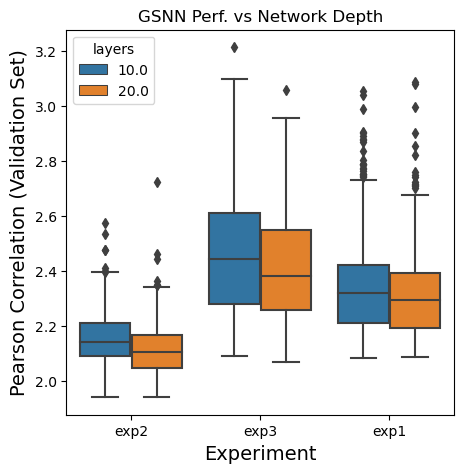

In [61]:
plt.figure(figsize=(5,5))
sbn.boxplot(x='exp', y='mse_val', hue='layers', data=res[lambda x: x.model4.isin(['gsnn'])])
plt.title('GSNN Perf. vs Network Depth')
plt.xlabel('Experiment', fontsize=14)
plt.ylabel('Pearson Correlation (Validation Set)', fontsize=14)
plt.show()

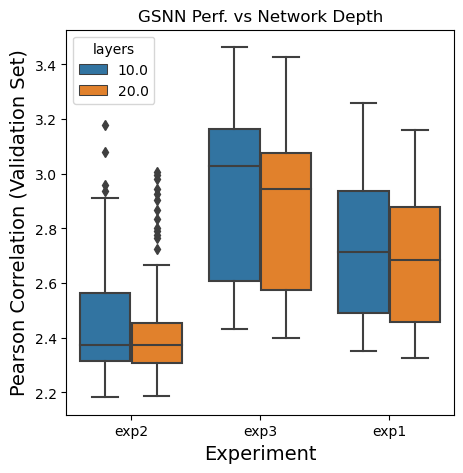

In [62]:
plt.figure(figsize=(5,5))
sbn.boxplot(x='exp', y='mse_val', hue='layers', data=res[lambda x: (x.model4 == 'gsnn-rand')])
plt.title('GSNN Perf. vs Network Depth')
plt.xlabel('Experiment', fontsize=14)
plt.ylabel('Pearson Correlation (Validation Set)', fontsize=14)
plt.show()

In [63]:
df = res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)]
df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')
df = df.assign(exp_norm_r_flat_val=lambda x: (x.r_flat_val - x['r_flat_val', 'mean'])/x['r_flat_val', 'var'])
df.head()

/tmp/ipykernel_23249/2144868085.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')
/tmp/ipykernel_23249/2144868085.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')


,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,fold,gnn,...,share_layers,two_layer_conv,name,exp,model2,model3,model4,"(r_flat_val, mean)","(r_flat_val, var)",exp_norm_r_flat_val
0,25.0,0.0,20.0,mse,../output/exp2-//proc/,cuda,0.25,100.0,2,NaN,...,0.0,0.0,model=gsnn_rand=False_cag=False,exp2,gsnn,gsnn,gsnn,0.589333,0.008308,11.497652
1,25.0,0.0,20.0,mse,../output/exp2-//proc/,cuda,0.25,100.0,2,NaN,...,0.0,0.0,model=gsnn_rand=False_cag=False,exp2,gsnn,gsnn,gsnn,0.589333,0.008308,13.702601
2,25.0,0.0,20.0,mse,../output/exp2-//proc/,cuda,0.25,100.0,2,NaN,...,0.0,0.0,model=gsnn_rand=False_cag=False,exp2,gsnn,gsnn,gsnn,0.589333,0.008308,14.218889
3,25.0,0.0,20.0,mse,../output/exp2-//proc/,cuda,0.25,100.0,2,NaN,...,0.0,0.0,model=gsnn_rand=False_cag=False,exp2,gsnn,gsnn,gsnn,0.589333,0.008308,14.377589
4,25.0,0.0,20.0,mse,../output/exp2-//proc/,cuda,0.25,100.0,2,NaN,...,0.0,0.0,model=gsnn_rand=False_cag=False,exp2,gsnn,gsnn,gsnn,0.589333,0.008308,14.556756


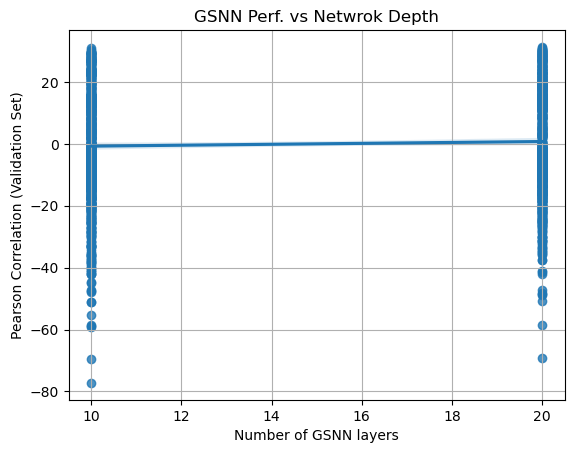

In [64]:
plt.figure()
sbn.regplot(x='layers', y='exp_norm_r_flat_val', data=df)
plt.title('GSNN Perf. vs Netwrok Depth')
plt.xlabel('Number of GSNN layers')
plt.ylabel('Pearson Correlation (Validation Set)')
plt.grid()
plt.show()

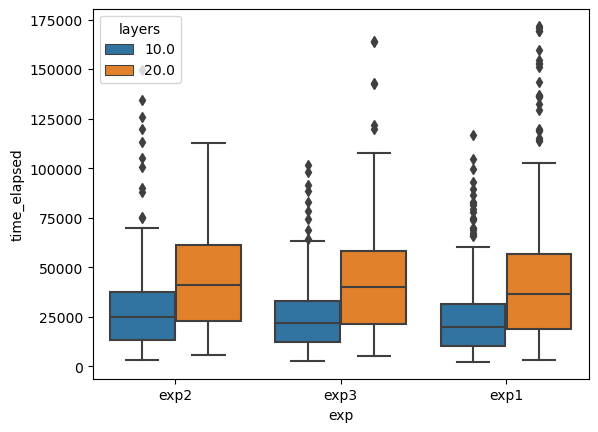

In [65]:
plt.figure()
sbn.boxplot(x='exp', y='time_elapsed', hue='layers', data=res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)])
plt.show()

# GSNN vs NN vs GNN 

Exclude `cell_agnostic` and `randomize` terms. 

In [66]:
bres.columns

Index(['index', 'batch', 'cell_agnostic', 'channels', 'crit', 'data', 'device',
       'dropout', 'epochs', 'fold', 'gnn', 'ignore_cuda', 'jk', 'layers', 'lr',
       'model', 'n_params', 'nonlin', 'norm', 'optim', 'out', 'randomize',
       'save_every', 'sched', 'siginfo', 'uid', 'wd', 'workers', 'dir_name',
       'mean_r_val', 'mean_r_test', 'median_r_val', 'median_r_test', 'r2_test',
       'r2_val', 'r_cell_test', 'r_cell_val', 'r_drug_test', 'r_drug_val',
       'r_dose_test', 'r_dose_val', 'mse_test', 'mse_val', 'r_flat_test',
       'r_flat_val', 'time_elapsed', 'eval_at_epoch', 'EXP_ID',
       'add_function_self_edges', 'balance_sample_weights', 'flag', 'init',
       'no_bias', 'no_residual', 'null_inflation', 'scale_channels_by_degree',
       'share_layers', 'two_layer_conv', 'name', 'exp', 'model2', 'model3',
       'model4'],
      dtype='object')

In [48]:
metric = 'mean_r_test'

model_order = ['gsnn', 'gsnn-rand', 'nn', 'nn-cell_agnostic', 'gnn-GIN', 'gnn-GAT', 'gnn-GCN']
model_names = ['GSNN', 'GSNN (randomized)', 'NN', 'NN (cell agnostic)', 'GIN', 'GAT', 'GCN'] 

print('\\begin{tabular}{|l|l|l|l|l|l|l|l|}')
print('\hline')
print('EXP &', ' & '.join(model_names), end=' ')
print('\\\\ \hline')

for exp in order: 

    tmp = bres[lambda x: x.exp == exp] 

    print(f'{exp} ', end='')
    for model_name in model_order: 

        tmp2 = tmp[lambda x: x.model4 == model_name]

        r = tmp2[metric].values
        _mean = np.mean(r)
        _ci95 = np.quantile(r, q=[0.025, 0.975])

        print(' & ', end='')

        print(np.round(_mean, 2), ' (', str(np.round(_ci95[0], 2)), ',', str(np.round(_ci95[1], 2)), ')', end='', sep='')

    print('\\\\ \\hline')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|l|l|}
\hline
EXP & GSNN & GSNN (randomized) & NN & NN (cell agnostic) & GIN & GAT & GCN \\ \hline
exp1  & 0.54 (0.51,0.56) & 0.44 (0.39,0.47) & 0.52 (0.48,0.53) & 0.39 (0.38,0.4) & 0.26 (0.16,0.36) & 0.1 (0.07,0.12) & 0.12 (0.06,0.19)\\ \hline
exp2  & 0.52 (0.45,0.6) & 0.41 (0.3,0.5) & 0.5 (0.41,0.58) & 0.38 (0.36,0.4) & 0.26 (0.07,0.45) & 0.11 (0.04,0.22) & 0.11 (0.04,0.18)\\ \hline
exp3  & 0.51 (0.49,0.52) & 0.38 (0.35,0.41) & 0.47 (0.44,0.48) & 0.36 (0.34,0.38) & 0.1 (0.08,0.13) & 0.06 (0.04,0.07) & 0.06 (0.04,0.08)\\ \hline
\end{tabular}


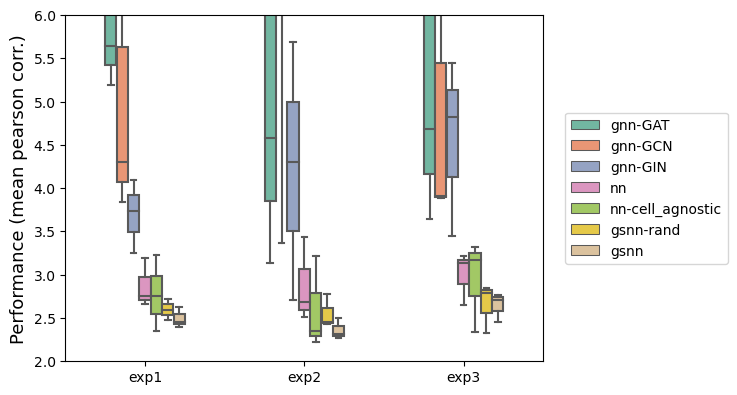

In [32]:
fontsize=13

f,axes = plt.subplots(1,1, figsize=(8,4), sharex=False)
g = sbn.boxplot(ax=axes, x='exp', y=metric, hue='model4', data=bres, order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
g.legend(loc='right', bbox_to_anchor=(1.4, 0.5), ncol=1)
axes.set_xlabel(None)
axes.set_ylabel('Performance (mean pearson corr.)', fontsize=fontsize)
#axes.set_title('General Performance')

#g = sbn.boxplot(ax=axes.flat[1], x='exp', y='r_cell_test', hue='model4', data=bres, order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
#axes.flat[1].get_legend().set_visible(False)
#axes.flat[1].set_ylabel('Performance (pearson)', fontsize=fontsize)
#axes.flat[1].set_xlabel('Experiment (unique biological networks and data subsets)', fontsize=fontsize)
#axes.flat[1].set_title('Cell-to-Cell Performance (Drug & Dose regressed out)')

plt.tight_layout()
plt.ylim(2,6)
plt.show()

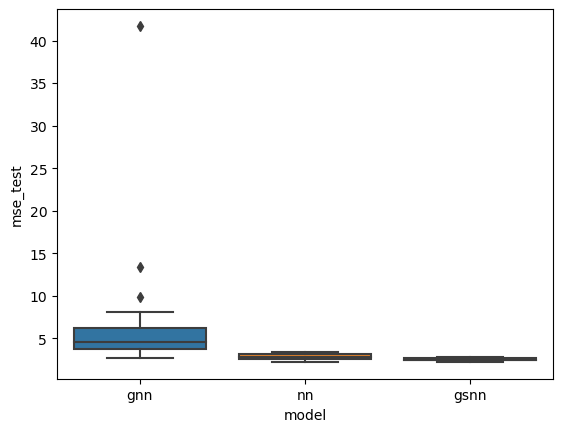

In [33]:
plt.figure()
sbn.boxplot(x='model', y=metric, data=bres)
plt.show()

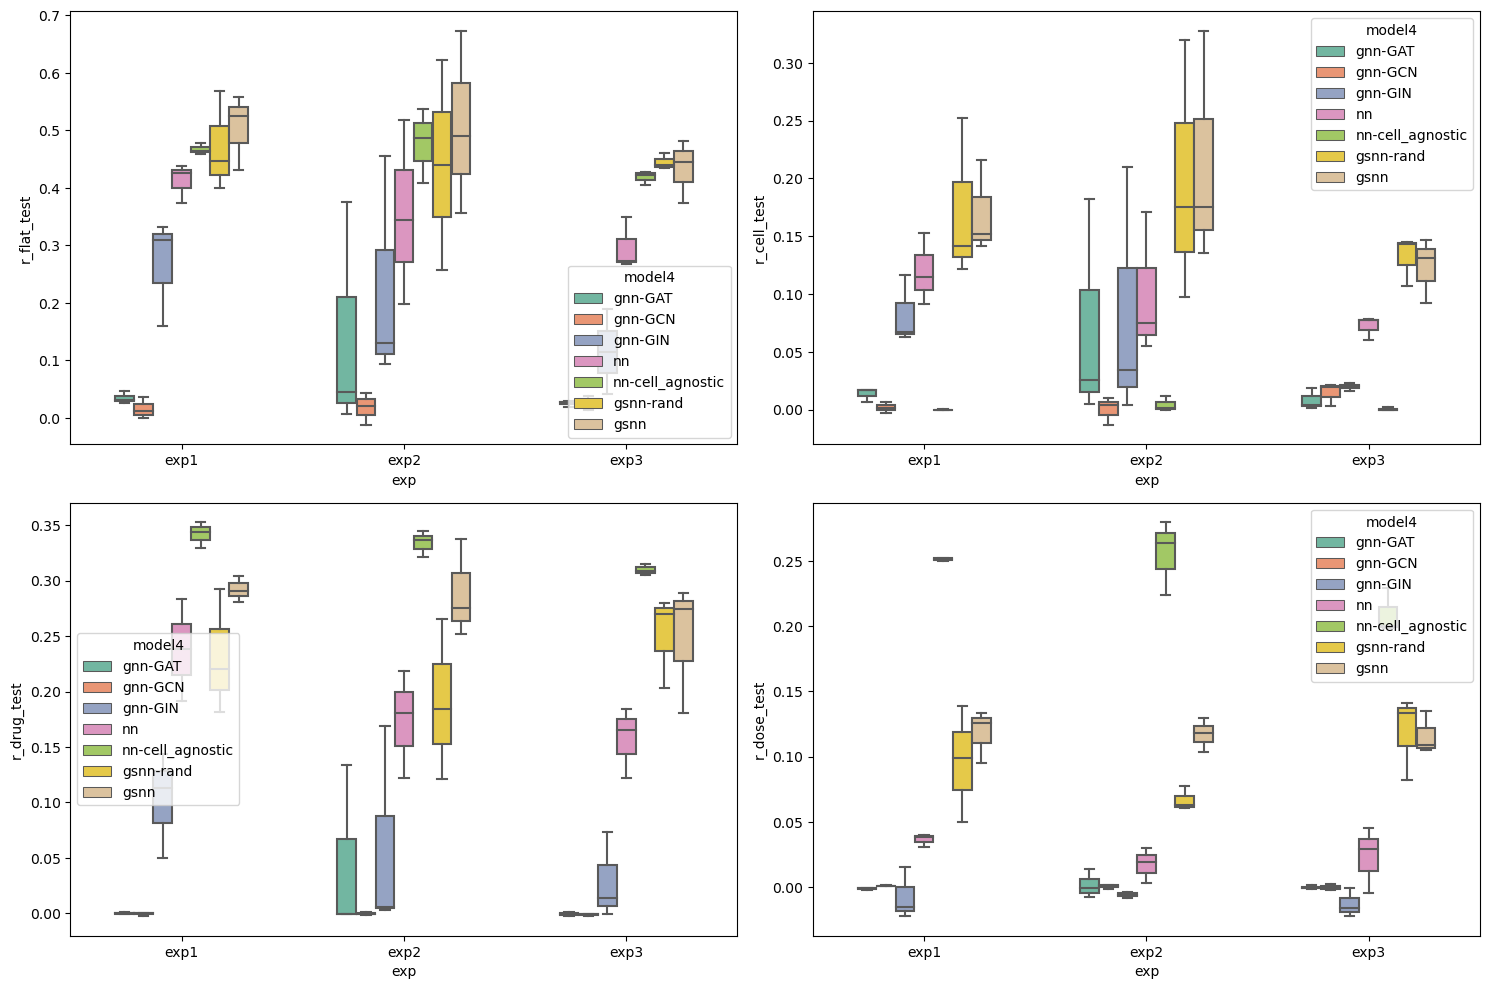

In [34]:
f,axes = plt.subplots(2,2, figsize=(15,10))
for ax, met in zip(axes.flat, ['r_flat_test', 'r_cell_test', 'r_drug_test', 'r_dose_test']):
    sbn.boxplot(x='exp', y=met, hue='model4', data=bres, order=order, width=0.6, orient='v', palette=sbn.color_palette("Set2"), ax=ax)
plt.tight_layout()
plt.show()

# GSNN vs Randomized-GSNN

In [112]:
metric = 'mean_r_test'

rand_res = {'exp':[], 'perc_diffs':[], 'diffs':[]}

f=0
for exp in res['exp'].unique(): 
    for i,row in res[lambda x: (x.model == 'gsnn')][['layers', 'dropout', 'fold', 'lr', 'channels', 'eval_at_epoch', 'exp', 'scale_channels_by_degree', 'add_function_self_edges']].drop_duplicates().iterrows(): 

        temp = res[lambda x: (x.layers == row.layers) & (x.dropout == row.dropout) & (x.lr == row.lr) & (x.channels == row.channels) & (x.fold == row.fold) & (x.exp == exp) & (x.eval_at_epoch == row.eval_at_epoch) & (x.scale_channels_by_degree == row.scale_channels_by_degree) & (x.add_function_self_edges == row.add_function_self_edges)]
        tru = temp[lambda x: x.randomize == 0.] 
        ran = temp[lambda x: x.randomize == 1.]
        if not ((tru.shape[0] == 1) & (ran.shape[0] == 1)): continue 

        try: 
            tru = temp[lambda x: x.randomize == 0.][metric].max()
            ran = temp[lambda x: x.randomize == 1.][metric].max()
            diff = tru-ran 
            rand_res['exp'].append(exp)
            rand_res['diffs'].append(diff)
            perc_diff = 100*(diff)/((tru + ran)/2)
            rand_res['perc_diffs'].append(perc_diff)
        except:
            f+=1
            print(f'failed [n={f}]', end='\r')
            raise


rand_res = pd.DataFrame(rand_res)

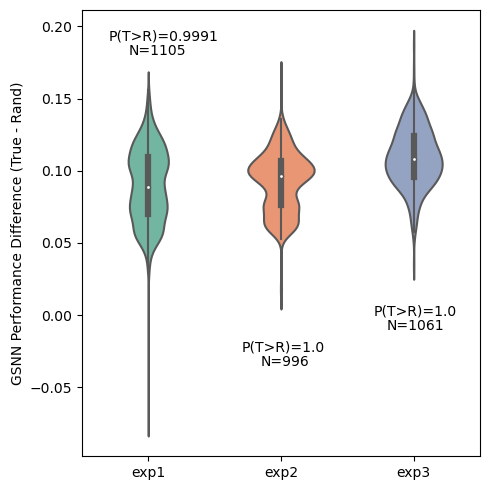

In [143]:
# Set the order of experiments as they appear in the plot
order = ['exp1', 'exp2', 'exp3']

# Define the size of the plot
plt.figure(figsize=(5, 5))

# Create the boxplot
ax = sbn.violinplot(x='exp', y='diffs', data=rand_res,
                 order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))

p1 = np.round((rand_res[lambda x: x.exp == 'exp1'].diffs.values > 0).mean(), 4)
n1 = (rand_res[lambda x: x.exp == 'exp1'].shape[0])
p2 = np.round((rand_res[lambda x: x.exp == 'exp2'].diffs.values > 0).mean(), 4)
n2 = (rand_res[lambda x: x.exp == 'exp2'].shape[0])
p3 = np.round((rand_res[lambda x: x.exp == 'exp3'].diffs.values > 0).mean(), 4)
n3 = (rand_res[lambda x: x.exp == 'exp3'].shape[0])

ax.annotate(f'P(T>R)={p1:.4f}', (-0.3,0.19), xytext=None, xycoords='data', textcoords=None)
ax.annotate(f'P(T>R)={p2:.1f}', (0.7,-0.025), xytext=None, xycoords='data', textcoords=None)
ax.annotate(f'P(T>R)={p3:.1f}', (1.7,-0.00), xytext=None, xycoords='data', textcoords=None)

ax.annotate(f'N={n1}', (-0.15,0.18), xytext=None, xycoords='data', textcoords=None)
ax.annotate(f'N={n2}', (0.85,-0.035), xytext=None, xycoords='data', textcoords=None)
ax.annotate(f'N={n3}', (1.8,-0.01), xytext=None, xycoords='data', textcoords=None)

plt.ylabel('GSNN Performance Difference (True - Rand)')
plt.xlabel('')

plt.tight_layout()
plt.show()

In [41]:
np.quantile(perc_diffs, q=[0.025, 0.975])

array([-23.31551096,  -6.03585188])

In [42]:
fontsize=12

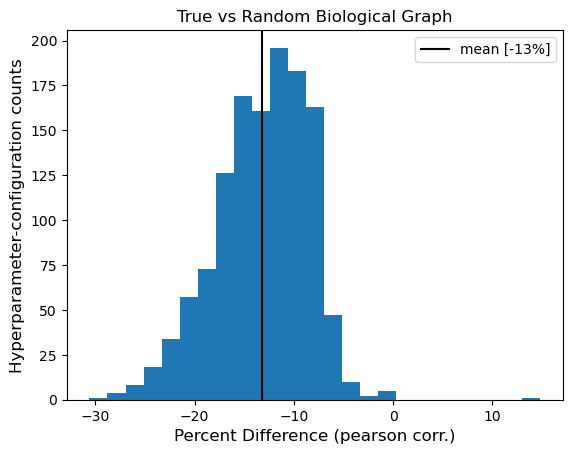

In [43]:
plt.figure()
plt.hist(np.array(perc_diffs), bins=25, density=False)
plt.axvline(np.mean(np.array(perc_diffs)), label=f'mean [{np.mean(perc_diffs):.0f}%]', c='k')
plt.xlabel('Percent Difference (pearson corr.)', fontsize=fontsize)
plt.ylabel('Hyperparameter-configuration counts', fontsize=fontsize)
plt.title('True vs Random Biological Graph')
plt.legend()
plt.show()

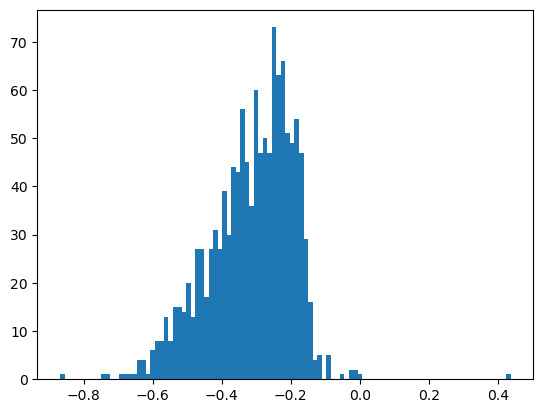

In [44]:
plt.figure()
plt.hist(diffs, bins=100)
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

exp2_0.0 v.s. exp2_1.0: t-test independent samples with Bonferroni correction, P_val=6.146e-01 stat=1.513e+00
exp1_0.0 v.s. exp1_1.0: t-test independent samples with Bonferroni correction, P_val=9.932e-02 stat=3.193e+00
exp3_0.0 v.s. exp3_1.0: t-test independent samples with Bonferroni correction, P_val=9.429e-03 stat=6.354e+00


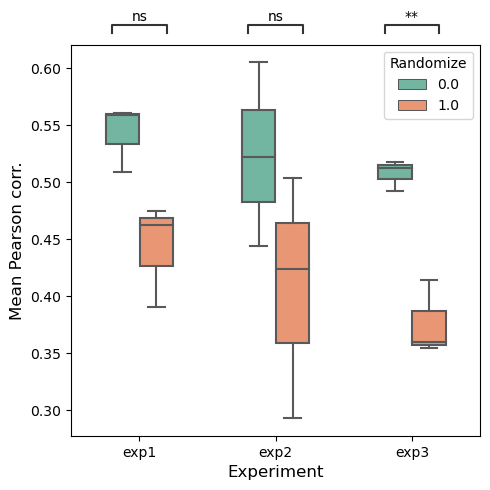

In [56]:
dat = bres[lambda x: (x.cell_agnostic.values == 0) & (x.model == 'gsnn')]


# Set the order of experiments as they appear in the plot
order = ['exp1', 'exp2', 'exp3']

# Define the size of the plot
plt.figure(figsize=(5, 5))

# Create the boxplot
ax = sbn.boxplot(x='exp', y='mean_r_test', hue='randomize', data=dat,
                 order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))

# Set the labels
plt.xlabel('Experiment', fontsize=12)
plt.ylabel('Mean Pearson corr.', fontsize=12)

# Define box pairs for comparison; you'll need to adjust this based on the groups you want to test
box_pairs = [(("exp1", 0.0), ("exp1", 1.0)),
             (("exp2", 0.0), ("exp2", 1.0)),
             (("exp3", 0.0), ("exp3", 1.0))]

# Add significance annotations
add_stat_annotation(ax, data=dat, x='exp', y='mean_r_test', hue='randomize',
                    box_pairs=box_pairs, comparisons_correction='bonferroni', order=order,
                    test='t-test_ind', text_format='star',
                    loc='outside', verbose=3)

# Adjust legend location
plt.legend(title='Randomize')#, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# `cell-agnostic` NN cell-cell performance 

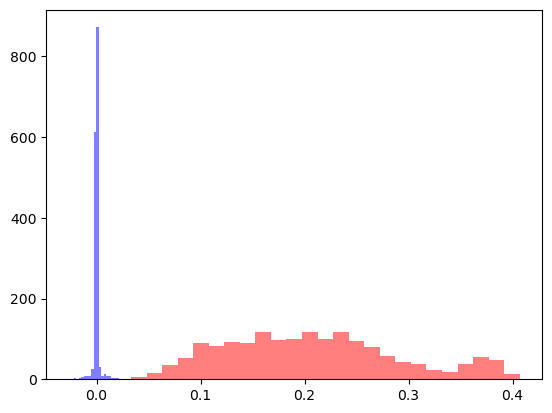

In [ ]:
plt.figure()
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 1.)].r_cell_val, bins=25, color='b', alpha=0.5)
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0.)].r_cell_val, bins=25, color='r', alpha=0.5)
plt.show()

# GSNN - what hyper-parameters work best?

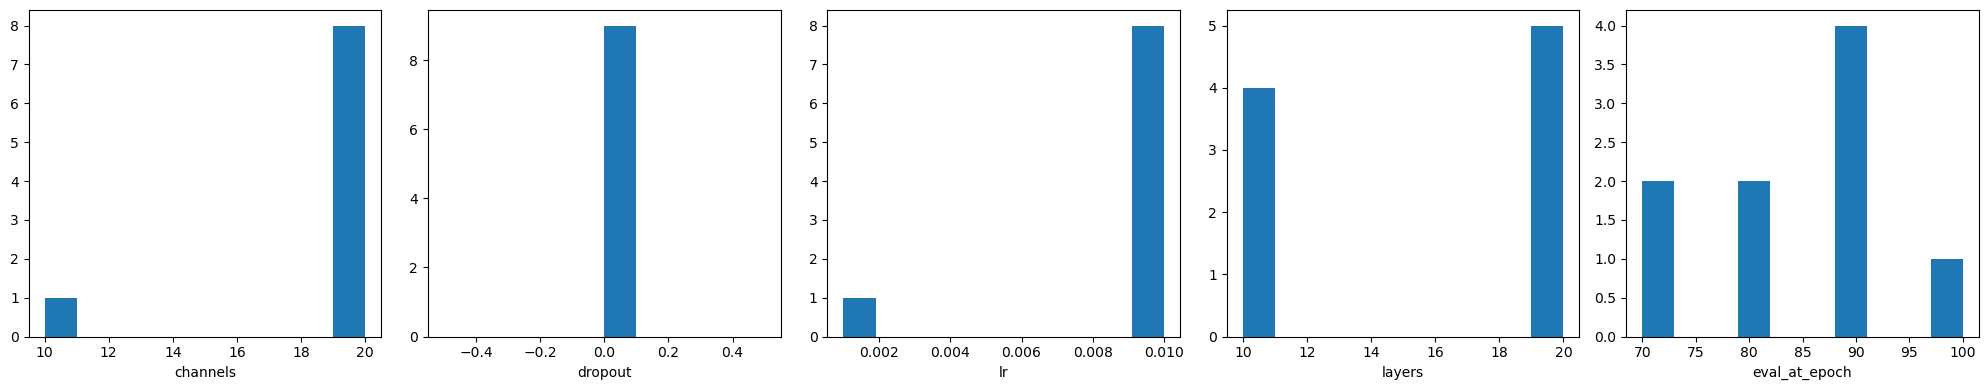

In [104]:
bgsnn = bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0.)]

f, axes = plt.subplots(1,5, figsize=(5*4,4))

for ax, hp in zip(axes.flat, ['channels', 'dropout', 'lr', 'layers', 'eval_at_epoch']): 
    ax.hist(bgsnn[hp])
    ax.set_xlabel(hp)

plt.tight_layout()
plt.show()

# NN - what hyper-parameters work best? ?

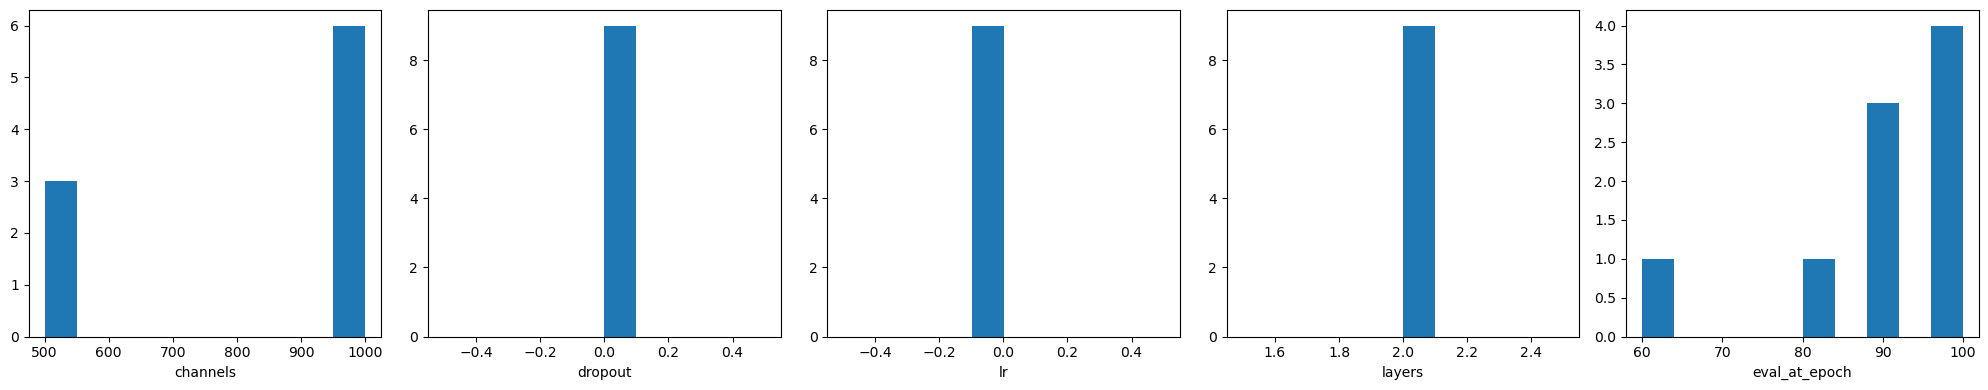

In [18]:
bgsnn = bres[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0.)]

f, axes = plt.subplots(1,5, figsize=(5*4,4))

for ax, hp in zip(axes.flat, ['channels', 'dropout', 'lr', 'layers', 'eval_at_epoch']): 
    ax.hist(bgsnn[hp])
    ax.set_xlabel(hp)

plt.tight_layout()
plt.show()

# GSNN vs NN vs GNN (all hyper-parameter runs)

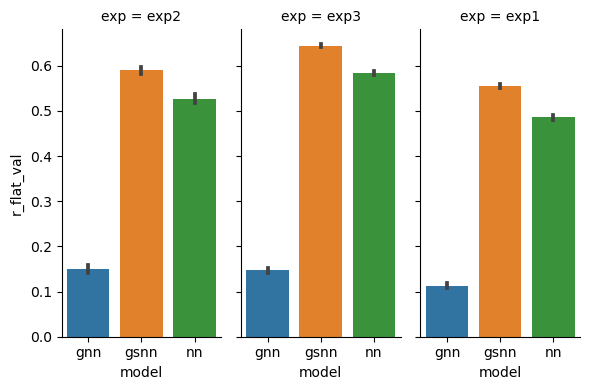

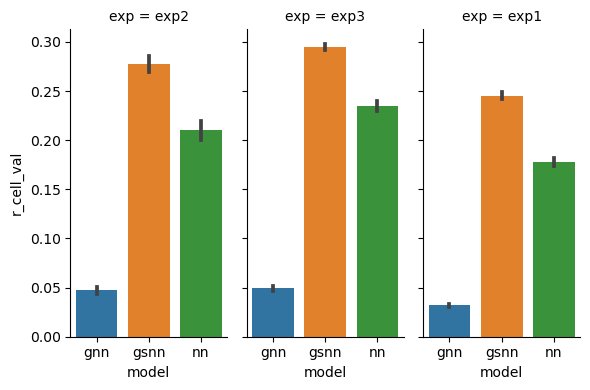

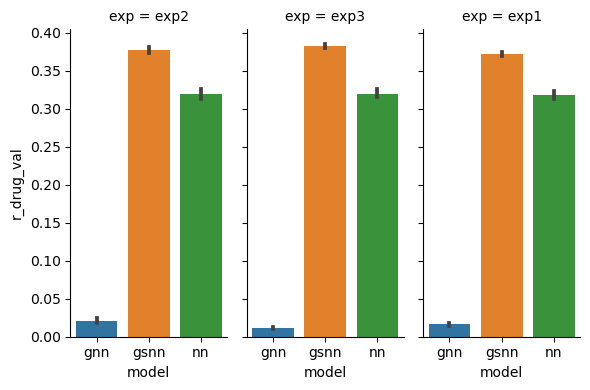

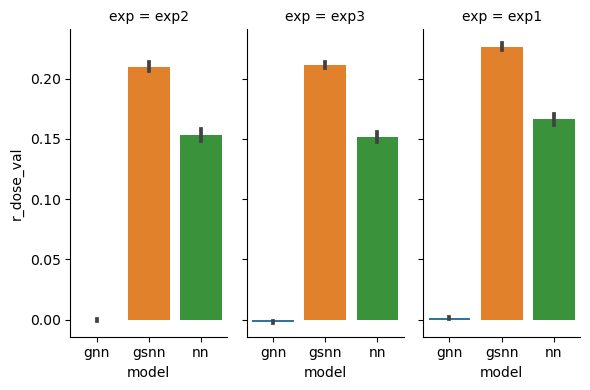

In [70]:
for i,metric in enumerate(['r_flat_val', 'r_cell_val', 'r_drug_val', 'r_dose_val']): 
    sbn.catplot(
        data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], x="model", y=metric, col="exp",
        kind="bar", height=4, aspect=.5)


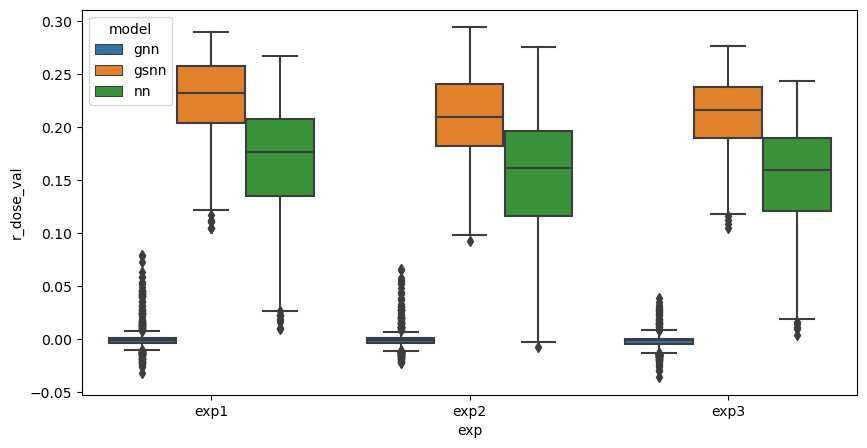

In [71]:
plt.figure(figsize=(10,5))
g = sbn.boxplot(x='exp', y=metric, hue='model', data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], order=order)
plt.show()